In [1]:
import csv
import sys
import glob, os
import copy
import gc
from tqdm import tqdm
import time
import math
from PIL import Image
import cv2
from shapely.geometry import MultiPolygon, Polygon, Point
import shapely.wkt
import shapely.affinity
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.plot import show
import rasterio.mask
import gdal
import ogr
import numpy as np
import random
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
import psutil
sys.setrecursionlimit(10**6)
from skimage import morphology
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
#import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.encoders import get_preprocessing_fn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import albumentations as album

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


# confirm Masuda sat images

In [3]:
image1 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20201112_Masuda_Urban.TIF'
image2 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20210315_Masuda_Urban.TIF'

psh1 = rio.open(image1)
psh1_meta = psh1.meta
psh1 = psh1.read().transpose([1,2,0]).astype('float')

psh2 = rio.open(image2)
psh2_meta = psh2.meta
psh2 = psh2.read().transpose([1,2,0]).astype('float')

In [4]:
psh1[:,:,0].max(), psh1[:,:,1].max(), psh1[:,:,2].max(), psh1[:,:,3].max()

(18685.0, 18640.0, 16445.0, 16564.0)

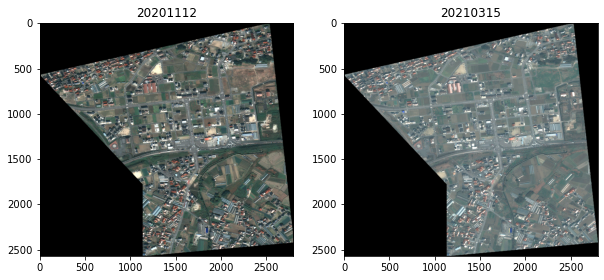

In [5]:
import utils

def stack_3band(img, i=1, j=2, k=4, gray=False):
    '''
    False color visuliazation
    [1,2,4] - RGB
    [7,3,1] - cement
    '''
    img_3band = np.stack([img[:, :, i],
                         img[:, :, j],
                         img[:, :, k]], axis=2)
    img_gray = (img[:, :, i] + img[:, :, j] + img[:, :, k]) / 3
    if gray:
        return img_gray[:, :, np.newaxis].astype('int32')
    else:
        return img_3band

psh1_rgb = stack_3band(psh1, 0,1,2)
psh2_rgb = stack_3band(psh2, 0,1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(psh1_rgb))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(psh2_rgb))

In [6]:
psh1_rgb.shape

(2568, 2800, 3)

In [7]:
psh1.shape, type(psh1)

((2568, 2800, 4), numpy.ndarray)

In [8]:
geojson1 = '../building_detection_data/masuda_sat_imgs/geojson/masuda_20201112_annotation.geojson'
geojson2 = '../building_detection_data/masuda_sat_imgs/geojson/masuda_20210315_annotation.geojson'

## create masks (transform .geojson into .tif)

In [9]:
dates = [20201112, 20210315]

def create_poly_mask(rasterSrc, vectorSrc, npDistFileName=''):

    # load vector
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

	# load raster
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
        
    dstPath = npDistFileName

	# create mask img
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[255], options=['COMPRESS=LZW'])
    dst_ds = 0
    
    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)
    
    return mask_image


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm(range(2)):
        
        src_raster_filename = "PHR1B_acq{}_Masuda_Urban.TIF".format(dates[idx])
        src_vector_filename = "masuda_{}_annotation.geojson".format(dates[idx])
        dst_filename = "masuda_mask{}.tif".format(dates[idx])

        src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
        src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
        dst_path = os.path.join(dst_dir, dst_filename)

        create_poly_mask(
            src_raster_path, src_vector_path, npDistFileName=dst_path
        )

In [10]:
img_path = '../building_detection_data/masuda_sat_imgs/raw_img/'
geojson_path = '../building_detection_data/masuda_sat_imgs/geojson/'
mask_path = '../building_detection_data/masuda_sat_imgs/mask/'

build_labels(img_path, geojson_path, mask_path)

100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

[INFO] Found 2 geojson files. Preparing building mask images...


## make difference image using mask

(2568, 2800, 1)


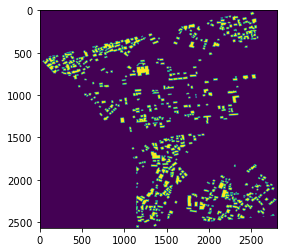

In [11]:
mask1 = rio.open(mask_path + "masuda_mask{}.tif".format(dates[0]))
data = mask1.read()
data = data.transpose(1,2,0)
print(data.shape)
mask1 = np.array(data)
mask1 = np.where(mask1>0, 1., 0.)
plt.imshow(mask1)

(2568, 2800, 1)


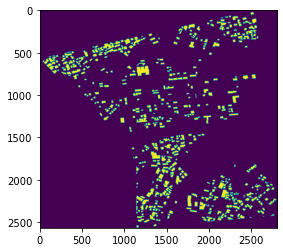

In [12]:
mask2 = rio.open(mask_path + "masuda_mask{}.tif".format(dates[1]))
data = mask2.read()
data = data.transpose(1,2,0)
print(data.shape)
mask2 = np.array(data)
mask2 = np.where(mask2>0, 1., 0.)
plt.imshow(mask2)

(2568, 2800, 1)


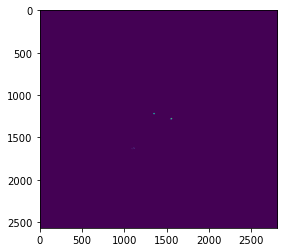

In [13]:
di = np.where(abs(mask1-mask2)>0, 1., 0.)
print(di.shape)
plt.imshow(di)

# make dataset / dataloader (tile size: 224x224)

In [14]:
image1 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20201112_Masuda_Urban.TIF'
image2 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20210315_Masuda_Urban.TIF'

psh1 = rio.open(image1)
psh1_meta = psh1.meta
psh1 = psh1.read().astype('float')

psh2 = rio.open(image2)
psh2_meta = psh2.meta
psh2 = psh2.read().astype('float')

In [15]:
path_4band = '../building_detection_data/masuda_sat_imgs/raw_img/'
path_geojson = '../building_detection_data/masuda_sat_imgs/geojson/'
path_mask = '../building_detection_data/masuda_sat_imgs/mask/'

def get_list(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

list_4band = get_list(path_4band)
list_geojson = get_list(path_geojson)

In [16]:
list_num = []

for i in range(len(list_geojson)):
    replaced = list_geojson[i].replace("masuda_", "")
    replaced = replaced.replace("_annotation.geojson", "")
    #print(replaced)
    list_num.append(int(replaced))
list_num

[20201112, 20210315]

In [17]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName=''):

    # load vector
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

	# load raster
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
        
    dstPath = npDistFileName

	# create mask img
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[255], options=['COMPRESS=LZW'])
    dst_ds = 0
    
    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)
    
    return mask_image


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm(list_num):

        src_raster_filename = "PHR1B_acq{}_Masuda_Urban.TIF".format(idx)
        src_vector_filename = "masuda_{}_annotation.geojson".format(idx)
        dst_filename = "mask_masuda_{}.tif".format(idx)

        src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
        src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
        dst_path = os.path.join(dst_dir, dst_filename)

        create_poly_mask(
            src_raster_path, src_vector_path, npDistFileName=dst_path
        )

In [18]:
build_labels(path_4band, path_geojson, path_mask)

100%|██████████| 2/2 [00:00<00:00, 12.82it/s]

[INFO] Found 2 geojson files. Preparing building mask images...


In [19]:
list_mask = get_list(path_mask)

In [20]:
mask1 = rio.open(path_mask + list_mask[0])
mask2 = rio.open(path_mask + list_mask[1])
mask1 = mask1.read().astype('float32')
mask2 = mask2.read().astype('float32')

In [21]:
psh1.shape, mask1.shape

((4, 2568, 2800), (1, 2568, 2800))

## make tiles (size: 224x224)

In [22]:
tile_size = 224
overlap = 48

band = 4

H = psh1.shape[1] # 2568
W = psh1.shape[2] # 2800

m = int((H-tile_size)/(tile_size-overlap))+1
n = int((W-tile_size)/(tile_size-overlap))+1
if (H-tile_size)/(tile_size-overlap)+1 != m:
    m = m + 1
if (W-tile_size)/(tile_size-overlap)+1 != n:
    n = n + 1
    
N = m * n

psh1_tiles = np.zeros((N, band, tile_size, tile_size))
psh2_tiles = np.zeros((N, band, tile_size, tile_size))

mask1_tiles = np.zeros((N, 1, tile_size, tile_size))
mask2_tiles = np.zeros((N, 1, tile_size, tile_size))

h_count = 0
h_over_flag = False

count = 0

while True:
    
    # impossible to make tile
    if tile_size > H or tile_size > W:
        break
    
    above = h_count*tile_size if h_count == 0 else h_count*(tile_size-overlap)
    below = h_count*tile_size+tile_size if h_count == 0 else h_count*(tile_size-overlap)+tile_size
    if below >= H:
        above = (H-1) - tile_size
        below = H-1
        h_over_flag = True
        
    w_count = 0
    w_over_flag = 0
    while True:
        left = w_count*tile_size if w_count == 0 else w_count*(tile_size-overlap)
        right = w_count*tile_size+tile_size if w_count == 0 else w_count*(tile_size-overlap)+tile_size
        if right >= W:
            left = (W-1) - tile_size
            right = W-1
            w_over_flag = True
        
        #print(above, below, left, right)
        
        psh1_tile = psh1[:, above:below, left:right]
        psh2_tile = psh2[:, above:below, left:right]
        mask1_tile = mask1[:, above:below, left:right]
        mask2_tile = mask2[:, above:below, left:right]
        #print(psh1_tile.shape)
        psh1_tiles[count,:,:,:] = psh1_tile
        psh2_tiles[count,:,:,:] = psh2_tile
        mask1_tiles[count,:,:,:] = mask1_tile
        mask2_tiles[count,:,:,:] = mask2_tile
        
        if w_over_flag == True:
            break
        
        w_count += 1
        count += 1
    
    if h_over_flag == True:
        break
    h_count += 1

In [23]:
m, n

(15, 16)

### don't include dark tiles in dataset

In [24]:
del_count = []

for i in range(N):
    if psh1_tiles[i].max() == 0:
        del_count.append(i)
        
_psh1_tiles = np.delete(psh1_tiles, del_count, 0)
_mask1_tiles = np.delete(mask1_tiles, del_count, 0)

del_count = []

for i in range(N):
    if psh2_tiles[i].max() == 0:
        del_count.append(i)
        
_psh2_tiles = np.delete(psh2_tiles, del_count, 0)
_mask2_tiles = np.delete(mask2_tiles, del_count, 0)

print(_psh1_tiles.shape, _psh2_tiles.shape)
print(_mask1_tiles.shape, _mask2_tiles.shape)

(169, 4, 224, 224) (169, 4, 224, 224)
(169, 1, 224, 224) (169, 1, 224, 224)


## search the index including change

In [25]:
di_members = []
for i in range(169):
    di = abs(_mask1_tiles[i] - _mask2_tiles[i])
    if di.max() != 0:
        di_members.append(i)
print(di_members)

[82, 83, 95, 103, 104, 113, 114]


255.0 0.0
255.0 0.0
255.0 0.0
255.0 0.0
255.0 0.0
255.0 0.0
255.0 0.0


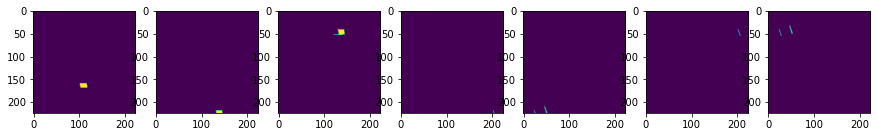

In [26]:
fig, axes = plt.subplots(1,7,figsize=(15,6))
for i in range(7):
    di = abs(_mask1_tiles[di_members[i]].transpose(1,2,0) - _mask2_tiles[di_members[i]].transpose(1,2,0))
    axes[i].imshow(di)
    print(di.max(), di.min())

## concatnate numpy arrays (pre image and post image)

In [27]:
psh_data = np.concatenate([_psh1_tiles, _psh2_tiles], 0)
psh_data.shape

(338, 4, 224, 224)

In [28]:
mask_data = np.concatenate([_mask1_tiles, _mask2_tiles], 0)
mask_data.shape

(338, 1, 224, 224)

## make dataset from numpy array

In [29]:
def preprocess(x, y, MAX):
    x = x / MAX
    x = torch.from_numpy(x.astype('float32'))#.permute(2,0,1)
    if y is not None:
        y = torch.from_numpy(y.astype('float32'))
        if y.max() != 0:
            y = y / y.max()
        #print(x.shape, y.shape)
        #y = F.one_hot(y, num_classes=2)#.permute(2,0,1)
    return x, y

def source_data(s_list, s_label_list):
    source_train, source_val, label_train, label_val = train_test_split(s_list, s_label_list, test_size=0.1)
    sMAX = s_list.max()
    return sMAX, s_list, s_label_list, source_train, source_val, label_train, label_val

def get_augmentation():
    border = cv2.BORDER_CONSTANT
    transform = [
        #album.Blur(),
        #album.OpticalDistortion(distort_limit=2, border_mode=border),
        #album.ElasticTransform(alpha=50, border_mode=border),
        album.Rotate(limit=15, border_mode=border),
        #album.ShiftScaleRotate(shift_limit=0.05, scale_limit=0, rotate_limit=0, border_mode=border),
        album.ShiftScaleRotate(shift_limit=0, scale_limit=0.4, rotate_limit=0, border_mode=border),
        #album.imgaug.transforms.IAAAffine(shear=20, mode='constant'),
        album.HorizontalFlip(),
        album.VerticalFlip()
    ]
    return album.Compose(transform)

class SatelliteDataset(Dataset):
    def __init__(self, data, label, Max, augmentation):
        super().__init__()
        self.data = data
        self.label = label
        self.data_size = len(self.data)
        self.max = Max
        self.augmentation = augmentation
        
    def __len__(self):
        return self.data_size
        
    def __getitem__(self, index):
        data, label = self.data[index,:,:,:], self.label[index,:,:,:]
        if self.augmentation is not None:
            data = data.transpose(1,2,0) # -> HxWxch
            label = label.transpose(1,2,0) # -> HxWxch
            aug = self.augmentation(image=data, mask=label)
            data, label = aug['image'], aug['mask']
            data = data.transpose(2,0,1) # -> chxHxW
            label = label.transpose(2,0,1)
        data, label = preprocess(data, label, self.max)
        return data, label

In [30]:
psh_max, _, _, psh_train, psh_val, mask_train, mask_val = source_data(psh_data, mask_data)

In [31]:
masuda_dataset = SatelliteDataset(psh_train, mask_train, psh_max, get_augmentation())
val_dataset = SatelliteDataset(psh_val, mask_val, psh_max, None)
print(masuda_dataset.__len__(), val_dataset.__len__())

304 34


torch.Size([4, 224, 224]) torch.Size([1, 224, 224])
(224, 224, 3)


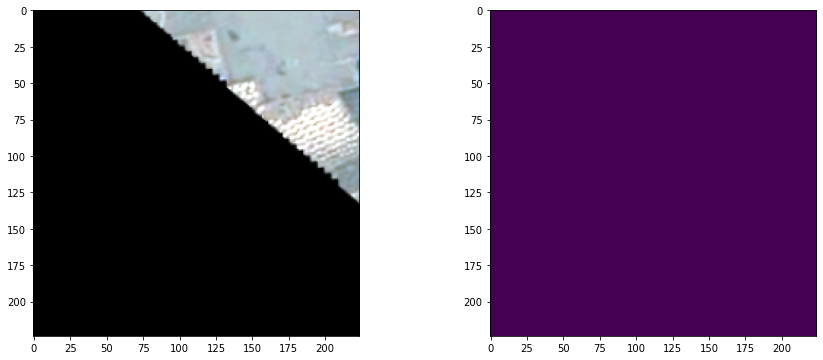

In [32]:
img, mask = masuda_dataset.__getitem__(10)
print(img.shape, mask.shape)

import utils

img = img.detach().numpy().transpose(1,2,0)
mask = mask.detach().numpy().squeeze()

img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2]], axis=2)
print(img.shape)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].imshow(utils.scale_percentile(img))
axes[1].imshow(mask)

## make dataloader

In [33]:

def get_loader(dataset, batch_size, shuffle=False):
    return DataLoader(dataset, batch_size, shuffle)

# use this method in training loop

In [34]:
val_loader = get_loader(val_dataset, 1, False)

# UNet fine tuning

In [35]:
#  configure
criterion = nn.BCELoss()

#  Metrics
epsilon = 1e-6
def IoU(pred, mask):
    pred = pred.cpu().numpy().astype(int)
    mask = mask.cpu().numpy().astype(int)
    intersection = (pred & mask).sum()
    union = (pred | mask).sum()
    out = (intersection + epsilon) / (union + epsilon)
    return out

# Early stopping
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [36]:
#  U-Net Model
#  https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

theta = (0.5, 0.5, 0.01, 0.01, 0.01) # change detectionにおける閾値

def double_conv(in_channels, out_channels, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, input_ch, n_class):
        super().__init__()
        
        self.dconv_down1 = double_conv(input_ch, 64, 1, 1)
        self.dconv_down2 = double_conv(64, 128, 1, 1)
        self.dconv_down3 = double_conv(128, 256, 1, 1)
        self.dconv_down4 = double_conv(256, 512, 1, 1)
        self.dconv_down5 = double_conv(512,1024, 1, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up4 = double_conv(512+1024, 512, 1, 1) # stride=2,padding=0は失敗
        self.dconv_up3 = double_conv(256+512, 256, 1, 1)
        self.dconv_up2 = double_conv(128+256, 128, 1, 1)
        self.dconv_up1 = double_conv(64+128, 64, 1, 1)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        #self.mode = mode # 1: 1枚の画像に対して学習/推論, 2: 2枚の画像を用いてDIを作成
        
    def forward(self, *x):
        if len(x) == 1:
            x = x[0]
            conv1 = self.dconv_down1(x)
            x = self.maxpool(conv1)
            conv2 = self.dconv_down2(x)
            x = self.maxpool(conv2)
            conv3 = self.dconv_down3(x)
            x = self.maxpool(conv3)
            conv4 = self.dconv_down4(x)
            x = self.maxpool(conv4)
            conv5 = self.dconv_down5(x)
            x = self.upsample(conv5)
            x = torch.cat([x, conv4], dim=1)
            x = self.dconv_up4(x)
            x = self.upsample(x)
            x = torch.cat([x, conv3], dim=1)
            x = self.dconv_up3(x)
            x = self.upsample(x)
            x = torch.cat([x, conv2], dim=1)
            x = self.dconv_up2(x)
            x = self.upsample(x)
            x = torch.cat([x, conv1], dim=1)
            x = self.dconv_up1(x)
            out = self.conv_last(x)
            return out
        elif len(x) == 2:
            # conv for each image
            conv_1 = self.dconv_down1(x[0].to(device))
            conv_2 = self.dconv_down1(x[1].to(device))
            # threshold processing
            di1 = abs(conv_1 - conv_2)
            di1 = torch.where(di1 <= theta[0], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down2(x_1)
            conv_2 = self.dconv_down2(x_2)
            # threshold processing
            di2 = abs(conv_1 - conv_2)
            di2 = torch.where(di2 <= theta[1], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down3(x_1)
            conv_2 = self.dconv_down3(x_2)
            # threshold processing
            di3 = abs(conv_1 - conv_2)
            di3 = torch.where(di3 <= theta[2], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down4(x_1)
            conv_2 = self.dconv_down4(x_2)
            # threshold processing
            di4 = abs(conv_1 - conv_2)
            di4 = torch.where(di4 <= theta[3], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down5(x_1)
            conv_2 = self.dconv_down5(x_2)
            # threshold processing
            di5 = abs(conv_1 - conv_2)
            di5 = torch.where(di5 <= theta[4], torch.tensor(0.).to(device), conv_2.to(device))
            
            # only convolution layers have params
            # convolution層は全て名称が存在（区別可能） -> 学習したパラメータはメソッド（dconv_down1とか）とセットで保存されているはず
            # len=2でネットワーク構造が変化しても, 当該メソッドは利用可能と判断される
            
            # decode
            x = self.upsample(di5)
            x = torch.cat([x, di4], dim=1)
            x = self.dconv_up4(x)
            x = self.upsample(x)
            x = torch.cat([x, di3], dim=1)
            x = self.dconv_up3(x)
            x = self.upsample(x)
            x = torch.cat([x, di2], dim=1)
            x = self.dconv_up2(x)
            x = self.upsample(x)
            x = torch.cat([x, di1], dim=1)
            x = self.dconv_up1(x)
            out = self.conv_last(x)
            return out
            
model = UNet(4, 1)
model = model.to(device)  

from torchsummary import summary
summary(model, (4, 224, 224))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           2,368
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [37]:
loaded_model = UNet(4,1)
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load('checkpoint_20210630_4band_for_SpaceNet_dataset.pt'))

<All keys matched successfully>

## confirm the segmentation ability for Masuda befor fine-tuning

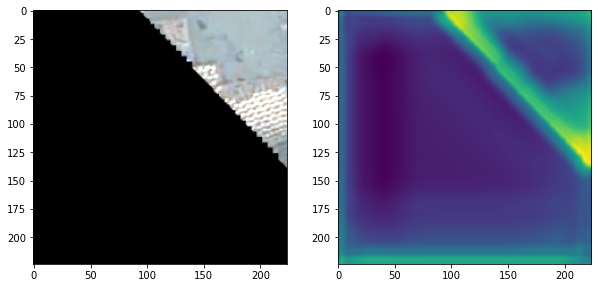

In [38]:
img, mask = masuda_dataset.__getitem__(10)
img = img[np.newaxis,:,:,:]
img = img.detach().numpy()

_img = img.squeeze()
_img = _img.transpose(1,2,0)
_img = _img[:,:,:3]

pred = loaded_model(torch.from_numpy(img.astype(np.float32)).to(device))
pred = pred.cpu().detach().numpy().squeeze()
#pred = np.where(pred>=0.5, 1, 0)

import utils
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(_img))
ax2.imshow(pred)

In [39]:
print(img.max(), mask.max())

0.14688806 tensor(0.)


In [40]:
print(loaded_model)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down5): Sequential(

In [41]:
for name, param in loaded_model.named_parameters():
    print("name: ", name)

name:  dconv_down1.0.weight
name:  dconv_down1.0.bias
name:  dconv_down1.2.weight
name:  dconv_down1.2.bias
name:  dconv_down2.0.weight
name:  dconv_down2.0.bias
name:  dconv_down2.2.weight
name:  dconv_down2.2.bias
name:  dconv_down3.0.weight
name:  dconv_down3.0.bias
name:  dconv_down3.2.weight
name:  dconv_down3.2.bias
name:  dconv_down4.0.weight
name:  dconv_down4.0.bias
name:  dconv_down4.2.weight
name:  dconv_down4.2.bias
name:  dconv_down5.0.weight
name:  dconv_down5.0.bias
name:  dconv_down5.2.weight
name:  dconv_down5.2.bias
name:  dconv_up4.0.weight
name:  dconv_up4.0.bias
name:  dconv_up4.2.weight
name:  dconv_up4.2.bias
name:  dconv_up3.0.weight
name:  dconv_up3.0.bias
name:  dconv_up3.2.weight
name:  dconv_up3.2.bias
name:  dconv_up2.0.weight
name:  dconv_up2.0.bias
name:  dconv_up2.2.weight
name:  dconv_up2.2.bias
name:  dconv_up1.0.weight
name:  dconv_up1.0.bias
name:  dconv_up1.2.weight
name:  dconv_up1.2.bias
name:  conv_last.weight
name:  conv_last.bias


In [42]:
update_param_names = ['dconv_down1.0.weight', 'dconv_down1.0.bias',
                     'dconv_down1.2.weight', 'dconv_down1.2.bias']
params_to_update = []

for name, param in loaded_model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print("store in params_to_update", name)

store in params_to_update dconv_down1.0.weight
store in params_to_update dconv_down1.0.bias
store in params_to_update dconv_down1.2.weight
store in params_to_update dconv_down1.2.bias


In [43]:
optimizer_fix = optim.Adam(params_to_update, lr=0.0001)

# fix the params other than params_to_update
for name, param in loaded_model.named_parameters():
    if name not in update_param_names:
        param.requires_grad = False

In [44]:
for name, param in loaded_model.named_parameters():
    print(param.requires_grad)

True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [45]:
def save_checkpoint(val_loss, min_val_loss, val_iou, patience, batch_size, epoch, model):
    print(f'val loss decreased ({min_val_loss:.3f} --> {val_loss:.3f}).  Saving model ...')
    min_val_loss = val_loss
    torch.save(model.state_dict(), f'{DataFolder}BATCH={batch_size}_EPOCH={epoch}_IOU={val_iou:.3f}_LOSS={val_loss:.3f}.pt')
    patience = 0
    return min_val_loss

#  configure
criterion = nn.BCELoss()

#  Metrics
epsilon = 1e-6
def IoU(pred, mask):
    pred = pred.cpu().numpy().astype(int)
    mask = mask.cpu().numpy().astype(int)
    intersection = (pred & mask).sum()
    union = (pred | mask).sum()
    out = (intersection + epsilon) / (union + epsilon)
    return out

# Early stopping
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#  train 
def train(model, optimizer, train_img, train_label, val_loader, batch_size, epochs):
    model.train()
    log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]}
    early_stopping = EarlyStopping(7, True)
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_iou = 0
        train_dataset_aug = SatelliteDataset(train_img, train_label, psh_max, get_augmentation())
        train_loader = get_loader(train_dataset_aug, batch_size, True)
        model.train()
        for data, mask in train_loader:
            data, mask = data.to(device), mask.to(device)
            mask = mask.view(-1)
            out = model(data)
            out = torch.sigmoid(out)
            out = out.view(-1)
            loss = criterion(out, mask)
            pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
            iou = IoU(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss.item())
            epoch_iou += float(iou.item())
        epoch_loss = epoch_loss / len(train_loader)
        epoch_iou = epoch_iou / len(train_loader)
        log["train_loss"].append(epoch_loss)
        log["train_iou"].append(epoch_iou)
        
        # validation
        val_loss = 0
        val_iou = 0
        model.eval()
        with torch.no_grad():
            for data, mask in val_loader:
                data, mask = data.to(device), mask.to(device)
                mask = mask.view(-1)
                out = model(data)
                out = torch.sigmoid(out)
                out = out.view(-1)
                loss = criterion(out, mask)
                pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
                iou = IoU(pred, mask)
                val_loss += float(loss.item())
                val_iou += float(iou.item())
        val_loss = val_loss / len(val_loader)
        val_iou = val_iou / len(val_loader)
        log["val_loss"].append(val_loss)
        log["val_iou"].append(val_iou)
        print('epoch{}:終了  train_loss={}, train_iou={}, val_loss={}, val_iou={}\n'.format(epoch, epoch_loss, epoch_iou, val_loss, val_iou))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(log["train_loss"], color='orangered', label='train')
    plt.plot(log["val_loss"], color='cyan', label='val')
    plt.legend(loc=0)
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('iou')
    plt.plot(log["train_iou"], color='orangered', label='train')
    plt.plot(log["val_iou"], color='cyan', label='val')
    plt.legend(loc=0)
    plt.show()
    fig.savefig("img/train_log.png")
    return log
    
        
#  test
threshold = 0.5
def test(model, load_test):
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()
    test_loss = 0
    test_iou = 0
    for data, mask in tqdm(load_test):
        data, mask = data.to(device), mask.to(device)
        mask = mask.view(-1)
        out = model(data)
        out = torch.sigmoid(out)
        out = out.view(-1)
        loss = criterion(out, mask)
        test_loss += float(loss.item())
        pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
        #pred_np = pred.to('cpu').detach().numpy().copy().reshape(224,224)
        #pred = morphology.binary_closing(pred_np, morphology.diamond(1)).astype(np.uint8)
        #pred = torch.from_numpy(pred).view(-1).to(device)
        iou = IoU(pred, mask)
        test_iou += float(iou.item())
    test_loss = test_loss/len(load_test)
    test_iou = test_iou/len(load_test)
    print('テスト終了  test_loss={},  test_iou={}'.format(test_loss, test_iou))

In [46]:
BATCH_SIZE = 1 # 元は16
EPOCHS = 200
STEPS_PER_EPOCH = 1

#train(loaded_model, optimizer_fix, psh_train, mask_train, val_loader, BATCH_SIZE, EPOCHS)

# train full layers

## use parameters trained for SpaceNet dataset as initial parameters 

In [47]:
loaded_full_model = UNet(4,1)
loaded_full_model = loaded_full_model.to(device)
loaded_full_model.load_state_dict(torch.load('checkpoint_20210630_4band_for_SpaceNet_dataset.pt'))

<All keys matched successfully>

In [48]:
optimizer_full = optim.Adam(loaded_full_model.parameters(), lr=0.0001)

In [49]:
BATCH_SIZE = 1 # 元は16
EPOCHS = 200
STEPS_PER_EPOCH = 1

#train(loaded_full_model, optimizer_full, psh_train, mask_train, val_loader, BATCH_SIZE, EPOCHS)

## confirm the accuracy of segmentation

In [50]:
# dataset = SatelliteDataset(train_img, train_label, psh_max, get_augmentation())
# loader = get_loader(train_dataset_aug, batch_size, True)
data_iter = iter(val_loader)
imgs, masks = data_iter.next()
print(imgs.shape)
img = imgs[0]
mask = masks[0]
print(img.shape, mask.shape)

img_for_pred = img.unsqueeze(0)
print(img_for_pred.shape)

torch.Size([1, 4, 224, 224])
torch.Size([4, 224, 224]) torch.Size([1, 224, 224])
torch.Size([1, 4, 224, 224])


In [51]:
loaded_full_model = UNet(4,1)
loaded_full_model = loaded_full_model.to(device)
loaded_full_model.load_state_dict(torch.load('checkpoint_train_0.78_val_0.74_masuda.pt'))

pred = loaded_full_model(img_for_pred.to(device))
pred = pred.cpu().detach().numpy().squeeze()
pred = np.where(pred>=0.5, 1, 0)
print(pred.shape)

_img = img.permute(1,2,0)
img_np = _img.to('cpu').detach().numpy().copy()
mask_np = mask.to('cpu').detach().numpy().copy()
print(img_np.shape, mask_np.shape)

(224, 224)
(224, 224, 4) (1, 224, 224)


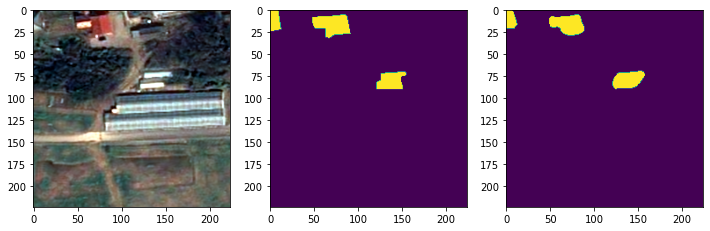

In [52]:
img_np_3band = np.stack([img_np[:,:,0], img_np[:,:,1], img_np[:,:,2]], axis=2)
mask_np_1band = np.squeeze(mask_np)
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(utils.scale_percentile(img_np_3band))
plt.subplot(1,3,2)
plt.imshow(mask_np_1band)
plt.subplot(1,3,3)
plt.imshow(pred)

## train using only Masuda data

In [53]:
only_masuda_model = UNet(4,1)
only_masuda_model = only_masuda_model.to(device)

In [54]:
optimizer_masuda = optim.Adam(only_masuda_model.parameters(), lr=0.0001)

In [55]:
for name, param in loaded_model.named_parameters():
    param.requires_grad = True

In [56]:
BATCH_SIZE = 1 # 元は16
EPOCHS = 200
STEPS_PER_EPOCH = 1

#train(only_masuda_model, optimizer_masuda, psh_train, mask_train, val_loader, BATCH_SIZE, EPOCHS)

In [57]:
# dataset = SatelliteDataset(train_img, train_label, psh_max, get_augmentation())
# loader = get_loader(train_dataset_aug, batch_size, True)
data_iter = iter(val_loader)
imgs, masks = data_iter.next()
print(imgs.shape)
img = imgs[0]
mask = masks[0]
print(img.shape, mask.shape)

img_for_pred = img.unsqueeze(0)
print(img_for_pred.shape)

torch.Size([1, 4, 224, 224])
torch.Size([4, 224, 224]) torch.Size([1, 224, 224])
torch.Size([1, 4, 224, 224])


In [58]:
only_masuda_model = UNet(4,1)
only_masuda_model = only_masuda_model.to(device)
only_masuda_model.load_state_dict(torch.load('checkpoint_masuda_full_layer_for_only_masuda_images.pt'))

pred = only_masuda_model(img_for_pred.to(device))
pred = pred.cpu().detach().numpy().squeeze()
pred = np.where(pred>=0.5, 1, 0)
print(pred.shape)

_img = img.permute(1,2,0)
img_np = _img.to('cpu').detach().numpy().copy()
mask_np = mask.to('cpu').detach().numpy().copy()
print(img_np.shape, mask_np.shape)

(224, 224)
(224, 224, 4) (1, 224, 224)


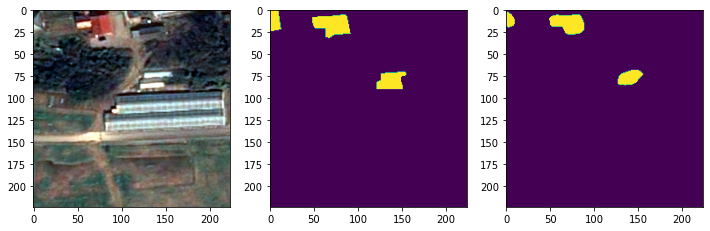

In [59]:
img_np_3band = np.stack([img_np[:,:,0], img_np[:,:,1], img_np[:,:,2]], axis=2)
mask_np_1band = np.squeeze(mask_np)
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(utils.scale_percentile(img_np_3band))
plt.subplot(1,3,2)
plt.imshow(mask_np_1band)
plt.subplot(1,3,3)
plt.imshow(pred)

### confirm the accuracy of segmentation for all region

In [60]:
_masuda_dataset = SatelliteDataset(psh_train, mask_train, psh_max, None)

_masuda_dataset.__getitem__(0)[0].shape
train_size = _masuda_dataset.__len__()
val_size = val_dataset.__len__()

all_size = train_size + val_size
iou_sum = 0
for i in range(train_size):
    img = _masuda_dataset.__getitem__(i)[0]
    mask = _masuda_dataset.__getitem__(i)[1]
    
    img = img.to(device)
    mask = mask.to(device)
    
    _img = img.unsqueeze(0)
    _mask = mask.view(-1)
    out = loaded_full_model(_img)
    out = torch.sigmoid(out)
    out = out.view(-1)
    pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
    iou = float(IoU(pred, _mask))
    iou_sum += iou
    print(iou)

iou_train = iou_sum / train_size

for i in range(val_size):
    img = val_dataset.__getitem__(i)[0]
    mask = val_dataset.__getitem__(i)[1]
    
    img = img.to(device)
    mask = mask.to(device)
    
    _img = img.unsqueeze(0)
    _mask = mask.view(-1)
    out = loaded_full_model(_img)
    out = torch.sigmoid(out)
    out = out.view(-1)
    pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
    iou = float(IoU(pred, _mask))
    iou_sum += iou
    print(iou)

iou_mean = iou_sum / all_size

0.7921637944038645
0.5845156061676062
0.8826879271293303
0.7715939448415863
1.0
0.9164602567177526
0.8237461037620442
0.8269287181499182
0.7956618190907283
0.8535879630053276
1.0
0.8349973726563334
1.0
0.793463611929426
0.7795005859749842
0.8512530315479314
1.0
0.8234190008917963
0.6355915847065061
0.7850097380294647
0.7018791266115393
0.8143895008637474
0.8213235294281872
0.8602227812216231
0.8543186180562075
0.4533678763557411
0.8010629429136032
0.8338380015454508
0.8349022068907592
0.8270223753640082
0.898952557055482
0.8669815033974886
0.8107317073632361
0.8347733617127777
0.7952249770640522
0.8908470722621676
0.844966574926763
0.8090984437048441
0.763424848777877
0.8235818236342198
0.7433986716761058
0.8722163309267146
0.8875659125797274
0.89670733747339
0.7292975444150214
1.0
0.6693869805144453
0.8221433182985566
0.5243770316769355
0.9436450839384847
0.8236391084429767
0.8551983782637711
0.8302997374055692
1.2499998437500196e-07
0.7966223500551123
1.0
0.838900530023487
1.0
0.7728

In [61]:
iou_train, iou_mean

(0.8082664715750486, 0.808052153497966)

torch.Size([4, 224, 224]) torch.Size([1, 224, 224])
(224, 224, 4) (1, 224, 224)


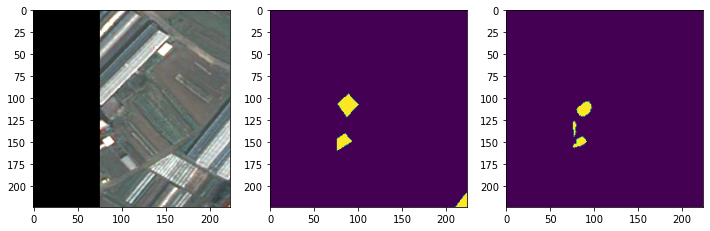

In [62]:
img = _masuda_dataset.__getitem__(25)[0]
mask = _masuda_dataset.__getitem__(25)[1]

print(img.shape, mask.shape)

_img = img.permute(1,2,0)
img_np = _img.to('cpu').detach().numpy().copy()
mask_np = mask.to('cpu').detach().numpy().copy()
print(img_np.shape, mask_np.shape)

img_for_pred = img.unsqueeze(0)
pred = loaded_full_model(img_for_pred.to(device))
pred = pred.cpu().detach().numpy().squeeze()
pred = np.where(pred>=0.5, 1, 0)

img_np_3band = np.stack([img_np[:,:,0], img_np[:,:,1], img_np[:,:,2]], axis=2)
mask_np_1band = np.squeeze(mask_np)
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(utils.scale_percentile(img_np_3band))
plt.subplot(1,3,2)
plt.imshow(mask_np_1band)
plt.subplot(1,3,3)
plt.imshow(pred)

In [63]:
img = masuda_dataset.__getitem__(0)[0]
_img = img.unsqueeze(0)

mask = masuda_dataset.__getitem__(0)[1]
_mask = mask.unsqueeze(0)
print(_img.shape, _mask.shape)

torch.Size([1, 4, 224, 224]) torch.Size([1, 1, 224, 224])


In [64]:
masuda_pre_dataset = SatelliteDataset(_psh1_tiles, _mask1_tiles, psh_max, None)
masuda_post_dataset = SatelliteDataset(_psh2_tiles, _mask2_tiles, psh_max, None)

pre_size = masuda_pre_dataset.__len__()
post_size = masuda_post_dataset.__len__()

iou_sum_pre = 0
for i in range(pre_size):
    img = masuda_pre_dataset.__getitem__(i)[0]
    mask = masuda_pre_dataset.__getitem__(i)[1]
    
    img = img.to(device)
    mask = mask.to(device)
    
    _img = img.unsqueeze(0)
    _mask = mask.view(-1)
    out = loaded_full_model(_img)
    out = torch.sigmoid(out)
    out = out.view(-1)
    pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
    iou = float(IoU(pred, _mask))
    iou_sum_pre += iou
    #print(iou)

print("iou_sum_pre: ", iou_sum_pre)
iou_mean_pre = iou_sum_pre / pre_size

iou_sum_post = 0
for i in range(post_size):
    img = masuda_post_dataset.__getitem__(i)[0]
    mask = masuda_post_dataset.__getitem__(i)[1]
    
    img = img.to(device)
    mask = mask.to(device)
    
    _img = img.unsqueeze(0)
    _mask = mask.view(-1)
    out = loaded_full_model(_img)
    out = torch.sigmoid(out)
    out = out.view(-1)
    pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
    iou = float(IoU(pred, _mask))
    iou_sum_post += iou
    #print(iou)

print("iou_sum_post: ", iou_sum_post)
iou_mean_post = iou_sum_post / post_size

print(iou_mean_pre, iou_mean_post)

iou_sum_pre:  136.8995115259205
iou_sum_post:  136.22211635639184
0.8100562812184645 0.8060480257774665


## change detection for Masuda images

### making difference image

In [65]:
# from _psh1_tiles, _psh2_tiles, _mask1_tiles, _mask2_tiles
di_members

[82, 83, 95, 103, 104, 113, 114]

torch.Size([4, 224, 224]) torch.Size([1, 224, 224]) (224, 224) (224, 224)


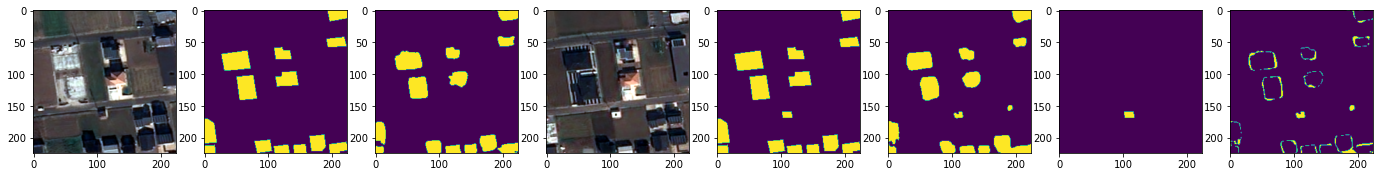

In [169]:
di_index = di_members[0]
img_pre = masuda_pre_dataset.__getitem__(di_index)[0]
mask_pre = masuda_pre_dataset.__getitem__(di_index)[1]
img_post = masuda_post_dataset.__getitem__(di_index)[0]
mask_post = masuda_post_dataset.__getitem__(di_index)[1]

img_pre_for_pred = img_pre.to(device)
img_post_for_pred = img_post.to(device)

img_pre_for_pred = img_pre_for_pred.unsqueeze(0)
pre_pred = loaded_full_model(img_pre_for_pred)
pre_pred = pre_pred.cpu().detach().numpy().squeeze()
pre_pred = np.where(pre_pred>=0.5, 1, 0)

img_post_for_pred = img_post_for_pred.unsqueeze(0)
post_pred = loaded_full_model(img_post_for_pred)
post_pred = post_pred.cpu().detach().numpy().squeeze()
post_pred = np.where(post_pred>=0.5, 1, 0)

img_pre_np = img_pre.permute(1,2,0).to('cpu').detach().numpy().copy()
img_post_np = img_post.permute(1,2,0).to('cpu').detach().numpy().copy()

img_pre_np_3band = np.stack([img_pre_np[:,:,0], img_pre_np[:,:,1], img_pre_np[:,:,2]], axis=2)
mask_pre_np = np.squeeze(mask_pre)

img_post_np_3band = np.stack([img_post_np[:,:,0], img_post_np[:,:,1], img_post_np[:,:,2]], axis=2)
mask_post_np = np.squeeze(mask_post)

di = abs(pre_pred - post_pred)
di_correct = abs(mask_pre_np - mask_post_np)
# if di_correct.max() != 0:
#     di_correct = di_correct / di_correct.max()

print(img_pre.shape, mask_pre.shape, pre_pred.shape, di.shape)

plt.figure(figsize=(24, 24))
plt.subplot(1,8,1)
plt.imshow(utils.scale_percentile(img_pre_np_3band))
plt.subplot(1,8,2)
plt.imshow(mask_pre_np)
plt.subplot(1,8,3)
plt.imshow(pre_pred)
plt.subplot(1,8,4)
plt.imshow(utils.scale_percentile(img_post_np_3band))
plt.subplot(1,8,5)
plt.imshow(mask_post_np)
plt.subplot(1,8,6)
plt.imshow(post_pred)
plt.subplot(1,8,7)
plt.imshow(di_correct)
plt.subplot(1,8,8)
plt.imshow(di)

### post processing

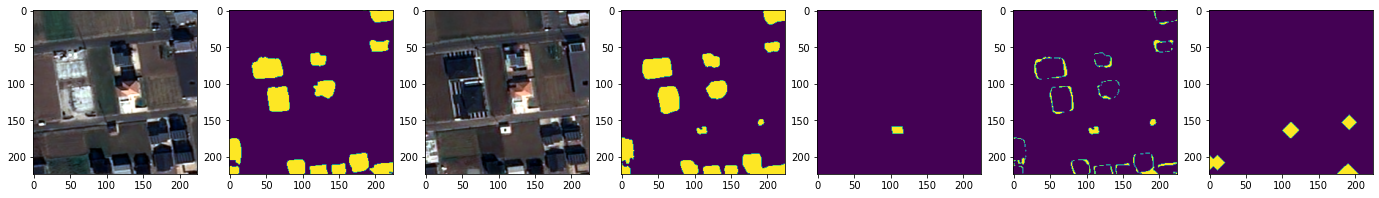

In [173]:
# delete contour line
# 1. pre processing for post processing
# -> closing, opening
di_closing = morphology.binary_closing(di, morphology.diamond(3)).astype(np.uint8)
di_opening = morphology.binary_opening(di_closing, morphology.diamond(4)).astype(np.uint8)
# emphasize change area
di_dilation = morphology.binary_dilation(di_opening, morphology.diamond(6)).astype(np.uint8)

plt.figure(figsize=(24, 24))
plt.subplot(1,7,1)
plt.imshow(utils.scale_percentile(img_pre_np_3band))
plt.subplot(1,7,2)
plt.imshow(pre_pred)
plt.subplot(1,7,3)
plt.imshow(utils.scale_percentile(img_post_np_3band))
plt.subplot(1,7,4)
plt.imshow(post_pred)
plt.subplot(1,7,5)
plt.imshow(di_correct)
plt.subplot(1,7,6)
plt.imshow(di)
plt.subplot(1,7,7)
plt.imshow(di_dilation)

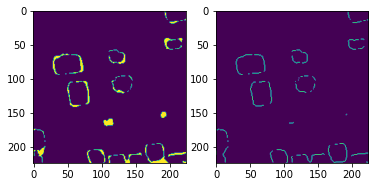

In [130]:
# 2. thinning processing
from skimage.morphology import skeletonize
di_skeleton = skeletonize(di_closing, method='lee')

plt.subplot(1,2,1)
plt.imshow(di_closing)
plt.subplot(1,2,2)
plt.imshow(di_skeleton)

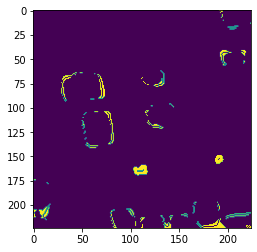

In [124]:
di_post = di_closing - di_skeleton
plt.imshow(di_post)

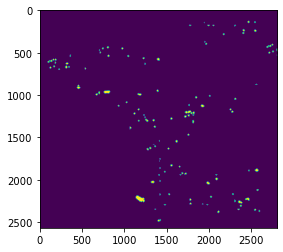

In [174]:
# Bonding tiles
psh1_tiles, psh2_tiles, mask1_tiles, mask2_tiles
tiles_len = psh1_tiles.shape[0]
H = 2568
W = 2800
di_all= np.zeros((H, W))

masuda_pre_dataset_full = SatelliteDataset(psh1_tiles, mask1_tiles, psh_max, None)
masuda_post_dataset_full = SatelliteDataset(psh2_tiles, mask2_tiles, psh_max, None)

m = 15
n = 16
tile_size = 224
overlap = 48

for i in range(m):
    above = i*tile_size if i == 0 else i*(tile_size-overlap)
    below = i*tile_size+tile_size if i == 0 else i*(tile_size-overlap)+tile_size
    if below >= H:
        above = (H-1) - tile_size
        below = H-1
    for j in range(n):
        left = j*tile_size if j == 0 else j*(tile_size-overlap)
        right = j*tile_size+tile_size if j == 0 else j*(tile_size-overlap)+tile_size
        if right >= W:
            left = (W-1) - tile_size
            right = W-1
        
        k = i*m+j
        img_pre = masuda_pre_dataset_full.__getitem__(k)[0]
        mask_pre = masuda_pre_dataset_full.__getitem__(k)[1]
        img_post = masuda_post_dataset_full.__getitem__(k)[0]
        mask_post = masuda_post_dataset_full.__getitem__(k)[1]

        img_pre_for_pred = img_pre.to(device)
        img_post_for_pred = img_post.to(device)

        img_pre_for_pred = img_pre_for_pred.unsqueeze(0)
        pre_pred = loaded_full_model(img_pre_for_pred)
        pre_pred = pre_pred.cpu().detach().numpy().squeeze()
        pre_pred = np.where(pre_pred>=0.5, 1, 0)

        img_post_for_pred = img_post_for_pred.unsqueeze(0)
        post_pred = loaded_full_model(img_post_for_pred)
        post_pred = post_pred.cpu().detach().numpy().squeeze()
        post_pred = np.where(post_pred>=0.5, 1, 0)

        img_pre_np = img_pre.permute(1,2,0).to('cpu').detach().numpy().copy()
        img_post_np = img_post.permute(1,2,0).to('cpu').detach().numpy().copy()

        img_pre_np_3band = np.stack([img_pre_np[:,:,0], img_pre_np[:,:,1], img_pre_np[:,:,2]], axis=2)
        mask_pre_np = np.squeeze(mask_pre)

        img_post_np_3band = np.stack([img_post_np[:,:,0], img_post_np[:,:,1], img_post_np[:,:,2]], axis=2)
        mask_post_np = np.squeeze(mask_post)

        di = abs(pre_pred - post_pred)
        
        # Morphology transformation
        di_closing = morphology.binary_opening(di, morphology.diamond(3)).astype(np.uint8)
        di_opening = morphology.binary_opening(di_closing, morphology.diamond(4)).astype(np.uint8)
        di_dilation = morphology.binary_dilation(di_opening, morphology.diamond(6)).astype(np.uint8)
        
        #di_skeleton = skeletonize(di_closing, method='lee')
        
        di_all[above:below, left:right] = di_dilation
        
plt.imshow(di_all)

In [71]:
a = np.array([[1,2,3,4,5], [6,7,8,9,10]])
replace = np.array([[0,0],[0,0]])
a[0:2, 0:2] = replace
a

array([[ 0,  0,  3,  4,  5],
       [ 0,  0,  8,  9, 10]])

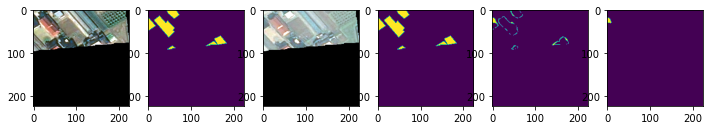

In [72]:
# Morphology transformation
di_opening = morphology.binary_opening(di, morphology.diamond(2)).astype(np.uint8)
plt.figure(figsize=(12,12))
plt.subplot(1,6,1)
plt.imshow(utils.scale_percentile(img_pre_np_3band))
plt.subplot(1,6,2)
plt.imshow(mask_pre_np)
plt.subplot(1,6,3)
plt.imshow(utils.scale_percentile(img_post_np_3band))
plt.subplot(1,6,4)
plt.imshow(mask_post_np)
plt.subplot(1,6,5)
plt.imshow(di)
plt.subplot(1,6,6)
plt.imshow(di_opening)

### unsupervised change detection

In [ ]:
loaded_full_model = UNet(4,1)
loaded_full_model = loaded_full_model.to(device)
loaded_full_model.load_state_dict(torch.load('checkpoint_train_0.78_val_0.74_masuda.pt'))

di_unsupervised = loaded_full_model(img_pre_for_pred, img_post_for_pred)
di_unsupervised = di_unsupervised.cpu().detach().numpy().squeeze()
di_unsupervised = np.where(di_unsupervised>=0.5, 1, 0)

plt.figure(figsize=(24, 24))
plt.subplot(1,8,1)
plt.imshow(utils.scale_percentile(img_pre_np_3band))
plt.subplot(1,8,2)
plt.imshow(mask_pre_np)
plt.subplot(1,8,3)
plt.imshow(pre_pred)
plt.subplot(1,8,4)
plt.imshow(utils.scale_percentile(img_post_np_3band))
plt.subplot(1,8,5)
plt.imshow(mask_post_np)
plt.subplot(1,8,6)
plt.imshow(post_pred)
plt.subplot(1,8,7)
plt.imshow(di_correct)
plt.subplot(1,8,8)
plt.imshow(di_unsupervised)

## Sekine-san's code

In [ ]:
DataFolder = "checkpoints/"

def get_bce_loss(pred, target):
    #pred = torch.sigmoid(pred)
    #return F.binary_cross_entropy(pred, target.to(torch.float32)
    return nn.BCEWithLogitsLoss()(pred, target.to(torch.float32))

def get_iou_bce(pred, target):
    pred = torch.sigmoid(pred)
    pred = torch.argmax(pred, 1)
    target = torch.argmax(target, 1)
    pred = pred.cpu().numpy().astype(int)
    target = target.cpu().numpy().astype(int)
    iou = (pred & target).sum() / ((pred | target).sum() + 1e-6 )
    return iou

def calc_metrics(model, data_loader, optimizer, steps, grad, epoch_loss, epoch_iou):
    steps = steps
    epoch_loss = epoch_loss
    epoch_iou = epoch_iou
    for data, label in data_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = get_bce_loss(pred, label)
        IoU = get_iou_bce(pred, label)
        if grad:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        steps += 1
        epoch_loss += float(loss.item())
        epoch_iou += float(IoU.item())
    return epoch_loss, epoch_iou, steps

def train(model, source_train, label_train, val_loader, sMAX, batch_size, epochs, steps_per_epoch):
    min_val_loss = 9999
    patience = 0
    optimizer = optimizer_fix
    scheduler = ReduceLROnPlateau(optimizer, 'max')
    for epoch in tqdm(range(epochs)):
        source_train_dataset_aug = SatelliteDataset(source_train, label_train, sMAX, get_augmentation())
        train_loader = get_loader(source_train_dataset_aug, batch_size, True)
        steps = 0
        model.train()
        while steps < steps_per_epoch:
            epoch_loss, epoch_iou, steps = calc_metrics(model, train_loader, optimizer, steps, True, 0, 0)
            epoch_loss = epoch_loss / (len(train_loader))
            epoch_iou = epoch_iou / (len(train_loader))
        model.eval()
        with torch.no_grad():
            val_loss, val_iou, _ = calc_metrics(model, val_loader, optimizer, 0, False, 0, 0)
            val_loss = val_loss / len(val_loader)
            val_iou = val_iou / len(val_loader)
            scheduler.step(val_loss)
        print(f'Epoch {epoch}')
        print(f'train_loss = {epoch_loss:.3f}, train_iou = {epoch_iou:.3f}')
        print(f'val_loss = {val_loss:.3f}, val_iou = {val_iou:.3f}')
        if val_loss < min_val_loss:
            min_val_loss = save_checkpoint(val_loss, min_val_loss, val_iou, patience, batch_size, epoch, model)
        else:
            patience += 1
        if patience > 3:
            print('Early stopped')
            torch.save(model.state_dict(), f'{DataFolder}BATCH={batch_size}_EPOCH={epoch}_IOU={val_iou:.3f}_LOSS={val_loss:.3f}.pt')
            break
            


In [ ]:
#train(model, psh_train, mask_train, val_loader, psh_max, BATCH_SIZE, EPOCHS, STEPS_PER_EPOCH)